# Lab 2:  Electric Field Mapping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# The following lines make plots in dark mode look reasonable.  If you are not using dark
# mode you don't need them, but you can also just leave them here and it should work fine.

dark_mode = True
# plotting choices for dark-mode
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

In [2]:
# Measured Ruler Distance in Pixels
length_pixels = 562.47 - 22.59
dlength_pixels = 5.0
length_cm = 19.0

lcal = length_cm*0.01/length_pixels
dlcal = dlength_pixels/length_pixels*lcal

print ("Ruler calibration: (%0.3e +/- %0.3e) meters/pixel" % (lcal,dlcal))

Ruler calibration: (3.519e-04 +/- 3.259e-06) meters/pixel


In [3]:
# Read in data from csv files
df1 = pd.read_csv("FieldMapping_Part2_2V.csv")
df2 = pd.read_csv("FieldMapping_Part2_10V.csv")

df = df2.copy()

In [4]:
# Define uncertainties in X and Y, in pixels
df['dX']=5.0
df['dY']=5.0

# Calculate X and Y positions, in meters, with uncertainties
df['X_m']=df['X']*lcal
df['dX_m']=df['X_m']*(df['dX']/df['X'] + dlcal/lcal)
df['Y_m']=df['Y']*lcal
df['dY_m']=df['Y_m']*(df['dY']/df['Y'] + dlcal/lcal)

df

,Y,X,dX,dY,X_m,dX_m,Y_m,dY_m
0,361.78,620.12,5.0,5.0,0.218239,0.003781,0.127321,0.002939
1,378.13,577.00,5.0,5.0,0.203064,0.003640,0.133075,0.002992
2,369.68,530.88,5.0,5.0,0.186833,0.003490,0.130102,0.002965
3,347.58,500.91,5.0,5.0,0.176285,0.003392,0.122324,0.002893
4,325.23,489.97,5.0,5.0,0.172435,0.003357,0.114458,0.002820
5,303.43,486.12,5.0,5.0,0.171080,0.003344,0.106786,0.002749
6,278.47,491.98,5.0,5.0,0.173143,0.003363,0.098002,0.002667
7,256.74,507.87,5.0,5.0,0.178735,0.003415,0.090355,0.002596
8,244.28,536.78,5.0,5.0,0.188909,0.003509,0.085969,0.002556


In [5]:
# Calculate the absolute positions of Q1 and Q2

X1_pixels = 530.04
dX1_pixels = 5.0
Y1_pixels = 302.07
dY1_pixels = 5.0

X2_pixels = 284.03
dX2_pixels = 5.0
Y2_pixels = 305.96
dY2_pixels = 5.0

X1 = X1_pixels*lcal
dX1 = X1*(dX1_pixels/X1_pixels + dlcal/lcal)
Y1 = Y1_pixels*lcal
dY1 = Y1*(dY1_pixels/Y1_pixels + dlcal/lcal)

X2 = X2_pixels*lcal
dX2 = X2*(dX2_pixels/X2_pixels + dlcal/lcal)
Y2 = Y2_pixels*lcal
dY2 = Y2*(dY2_pixels/Y2_pixels + dlcal/lcal)

print (X1,dX1,Y1,dY1,X2,dX2,Y2,dY2)

0.18653700822404978 0.003487228719567772 0.10630751278061791 0.0027441979030582526 0.09995869452470918 0.0026853994825212003 0.10767652070830554 0.0027568767199035484


In [6]:
# Calculate r1 and r2, and errors

df['r1'] = np.sqrt((df['X_m']-X1)**2 + (df['Y_m']-Y1)**2)
df['r2'] = np.sqrt((df['X_m']-X2)**2 + (df['Y_m']-Y2)**2)

df['dr1'] = 1/df['r1']*(np.abs((df['X_m']-X1))*(dX1+df['dX_m']) + (np.abs(df['Y_m']-Y1))*(dY1+df['dY_m']))
df['dr2'] = 1/df['r2']*(np.abs((df['X_m']-X2))*(dX1+df['dX_m']) + (np.abs(df['Y_m']-Y2))*(dY2+df['dY_m']))

df['ID'] = 1.0/df['r1']-1.0/df['r2']
df['dID'] = 1/df['r1']**2*df['dr1'] + 1/df['r2']**2*df['dr2']

df

,Y,X,dX,dY,X_m,dX_m,Y_m,dY_m,r1,r2,dr1,dr2,ID,dID
0,361.78,620.12,5.0,5.0,0.218239,0.003781,0.127321,0.002939,0.038034,0.119900,0.009198,0.008103,17.952010,6.921987
1,378.13,577.00,5.0,5.0,0.203064,0.003640,0.133075,0.002992,0.031459,0.106187,0.008625,0.008296,22.370461,9.451329
2,369.68,530.88,5.0,5.0,0.186833,0.003490,0.130102,0.002965,0.023796,0.089722,0.005795,0.008186,30.878582,11.251018
3,347.58,500.91,5.0,5.0,0.176285,0.003392,0.122324,0.002893,0.019016,0.077719,0.008456,0.007821,39.719565,24.679056
4,325.23,489.97,5.0,5.0,0.172435,0.003357,0.114458,0.002820,0.016288,0.072793,0.008710,0.007334,47.657692,34.213640
5,303.43,486.12,5.0,5.0,0.171080,0.003344,0.106786,0.002749,0.015464,0.071127,0.006998,0.006900,50.606247,30.627097
6,278.47,491.98,5.0,5.0,0.173143,0.003363,0.098002,0.002667,0.015761,0.073821,0.008674,0.007502,49.903363,36.296063
7,256.74,507.87,5.0,5.0,0.178735,0.003415,0.090355,0.002596,0.017759,0.080658,0.007830,0.007891,43.912209,26.040814
8,244.28,536.78,5.0,5.0,0.188909,0.003509,0.085969,0.002556,0.020476,0.091561,0.006075,0.008056,37.916197,15.450390


<ErrorbarContainer object of 3 artists>

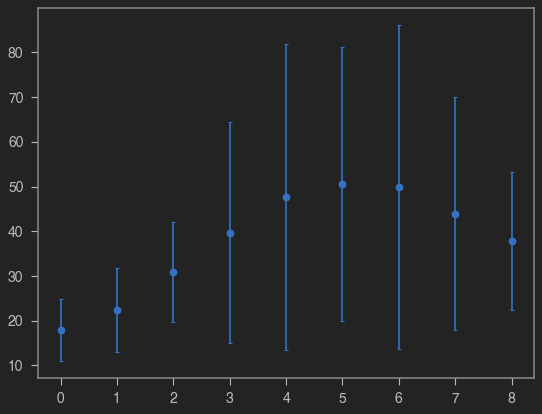

In [7]:
# Plot the inverse difference, 1/r1-1/r2, for all data points that we have
plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(df.index, df['ID'], xerr=0, yerr=df['dID'], fmt='o', capsize=2, capthick=1)

25.833375713696633 4.474356063834456


<ErrorbarContainer object of 3 artists>

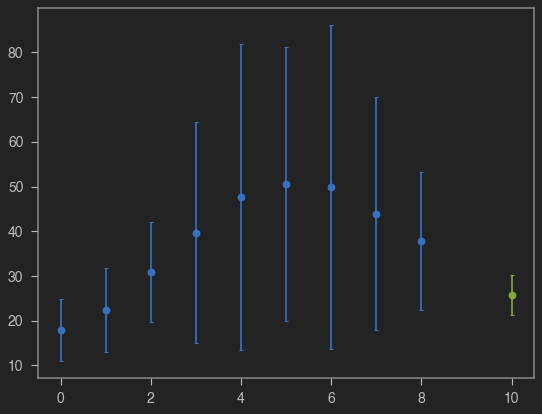

In [8]:
# Calculate the weighted average of the inverse difference values.
def w_avg(df, values, weights):
    d = df[values]
    w = 1.0/df[weights]**2
    return (d * w).sum()/w.sum(), np.sqrt(1/w.sum())

average, daverage = w_avg(df, 'ID', 'dID')
print (average,daverage)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(df.index, df['ID'], xerr=0, yerr=df['dID'], fmt='o', capsize=2, capthick=1)
npts=len(df)
plt.errorbar(npts+1, average, xerr=0, yerr=daverage, fmt='o', capsize=2, capthick=1)

In [9]:
# Now, just do the same procedure for the other voltage values!

# As you complete each voltage line analysis, add the extracted averages to the 
# csv file called FieldMapping_Averages.csv

In [10]:
dfavg = pd.read_csv("FieldMapping_Averages.csv")

df = dfavg.copy()
df

,Voltage,dVoltage,Average,dAverage
0,2.0,0.001,-26.0884,4.31981
1,10.0,0.001,25.8333,4.47400


Beta: [0.15407816 6.01965267]
Beta Std Error: [9.07040558e-32 2.35518819e-30]
Beta Covariance: [[0.0003406  0.00035342]
 [0.00035342 0.22963642]]
Residual Variance: 2.4155189959136455e-59
Inverse Condition #: 0.03984002233198974
Reason(s) for Halting:
  Parameter convergence

Final Result: Y = (0.154078160 +/- 0.000000000) X + (6.019652669 +/- 0.000000000)


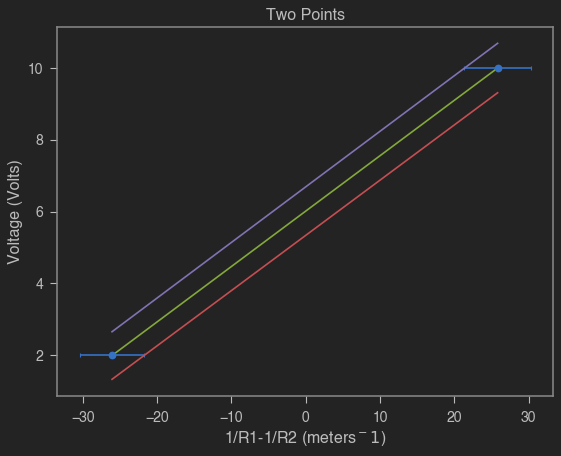

In [11]:
xi = df['Average']
yi = df['Voltage']
sigmaxi = df['dAverage']
sigmayi = df['dVoltage']

##############################

from scipy.odr import *

def fitfunction(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[1., 2.]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,16.0,axis=0)
upper = np.percentile(ysample,84.0,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('1/R1-1/R2 (meters$^-1$)')
plt.ylabel('Voltage (Volts)')
plt.title('Two Points')
plt.show()